In [0]:
!pip install -U -q PyDrive
!pip install -U -q scipy

## Assignment#2 Image Segmentation (Total 60 Points)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
#-----------------------------------
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from urllib.request import urlretrieve
#-----------------------------------
from PIL import Image
from scipy import io
#-----------------------------------
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import SpectralClustering


In [0]:
def getImagesFormDataSet():
  if not os.path.isfile('BSR_bsds500.tgz'):
    print("Download file... " +'BSR_bsds500.tgz' + " ...")
    urlretrieve('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz','BSR_bsds500.tgz')
    print("File downloaded")
  if not os.path.isfile('content/BSR_bsds500.tgz'):
    print('File is unzipped')
    !apt-get install p7zip-full
    !p7zip -d BSR_bsds500.tgz
    !tar -xvf BSR_bsds500.tgz

In [0]:
def readImage(filename):
  file = "/content/BSR/BSDS500/data/images/train/" +(filename)+'.jpg'
  pil_im = Image.open(file) 
  im_array = np.asarray(pil_im)
  plt.imshow(im_array)
  plt.show()
  mat = io.loadmat('/content/BSR/BSDS500/data/groundTruth/train/'+(filename) + '.mat')
  fig = plt.figure(figsize=(15, 20))
  for i in range((mat['groundTruth'].shape[1] - 1)):
    seg = np.array(mat['groundTruth'][0, i][0, 0][0])
    bud = np.array(mat['groundTruth'][0, i][0, 0][1])
    fig.add_subplot((mat['groundTruth'].shape[1]), 2, (i * 2 + 1))
    plt.axis('off')
    plt.imshow(seg)
    fig.add_subplot((mat['groundTruth'].shape[1]), 2, (i * 2 + 1) + 1)
    plt.axis('off')
    plt.imshow(bud)
  plt.show()
  return im_array,mat

In [0]:
def getConditionalEntropy(segmented_results,mat):
  cond_entropy_list = []
  for m in range(len(segmented_results)):
    pred = segmented_results[m].flatten()
    for n in range(mat['groundTruth'].shape[1]):
      print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
      truth = mat['groundTruth'][0, n][0, 0][0].flatten()
      predicted_labels = np.unique(pred)
      predicted_indicies = np.array([ np.where(pred == i) for i in predicted_labels if np.where(pred == i)[0].size > 0])
      clusters = [0 for x in predicted_labels]
      for i in range(len(predicted_labels)):
        clusters[i] = np.array([truth[j] for j in predicted_indicies[i]])
      cond_entropy_ = np.zeros(len(clusters))
      for i,c in zip(clusters,range(len(clusters))):
        print("-------------------------------------------")
        print(c,"'th cluster => ", np.array(i).flatten())
        sum_ = np.array([(np.array(i) == j).sum() for j in np.unique(truth)])
        print("Sum of Elements:", sum_)
        #print('---------------')
        entropy_ = np.array([j / (1.0 * len(i[0])) for j in sum_])
        entropy_ = np.array([math.log(j) * (j) * -1.0 for j in entropy_ if j != 0])
        #print("Entropy:",np.around(entropy_,decimals=3))
        cond_entropy_[c] = sum(entropy_) * len(i[0]) * 1.0 / len(pred)
      cond_entropy_list.append(sum(cond_entropy_))
      print("Conditional Entropy:",sum(cond_entropy_))
  return np.sum(cond_entropy_list)

In [0]:
def getSegmentedKMeans(im_array,mat,Ks):
  im_array = im_array.reshape(154401,3)
  segmented_results = np.empty([len(Ks),481,321])
  for k,i in zip((Ks),range(len(Ks))):
    seg = (KMeans(n_clusters=k, random_state=0).fit(im_array))
    segmented_results[i] = np.array([j for j in seg.labels_]).reshape(481,321)
    plt.imshow(segmented_results[i])
    plt.show()
  return (segmented_results)

In [0]:
def getSegmentedCuts(im_array,mat,Ks):
  im_array = im_array.reshape(154401,3)
  segmented_results = np.empty([len(Ks),481,321])
  for k,i in zip((Ks),range(len(Ks))):
    seg = (SpectralClustering(n_clusters=k, n_neighbors=5).fit(im_array))
    segmented_results[i] = np.array([j for j in seg.labels_]).reshape(481,321)
    plt.imshow(segmented_results[i])
    plt.show()
  return (segmented_results)

In [0]:
def getFMeasure(segmented_results,mat):
  for i in range(len(segmented_results)):
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    pred = segmented_results[i].flatten()
    f1_score_list = []
    for j in range(mat['groundTruth'].shape[1]):
      truth = mat['groundTruth'][0, j][0, 0][0].flatten()
      con = contingency_matrix(truth, pred, eps=None, sparse=False).T
      prec = 0.0
      recall = 0.0
      f1_score = 0.0
      for k in range(len(con)):
        idx = np.argmax(con[k])
        prec = con[k][idx] * 1.0 / sum(con[k])
        recall = con[k][idx] * 1.0 / sum(con[:,idx])
        f1_score += (2.0 * prec * recall / (prec + recall))
      f1_score /= len(con) * 1.0
      f1_score_list.append(f1_score)
      print("F1-Score --> Ground Truth [",j,"] Segment # [",i,"]: ",np.around(f1_score,decimals=2))
  return np.array(f1_score_list)

# Download the dataset and understand the format (5 Points)

In [9]:
getImagesFormDataSet()

File is unzipped
Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
/usr/bin/p7zip: BSR_bsds500.tgz: unknown suffix
BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source/csa_defs.h
BSR/bench/source/Timer.hh
BSR/bench/source/Exception.cc
BSR/bench/source/String.cc
BSR/bench/source/Array.hh
BSR/bench/source/kofn.hh
BSR/bench/source/Random.hh
BSR/bench/source/Exception.hh
BSR/b

# Visualize the image and the ground truth segmentation (5 points)

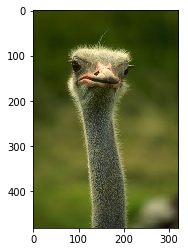

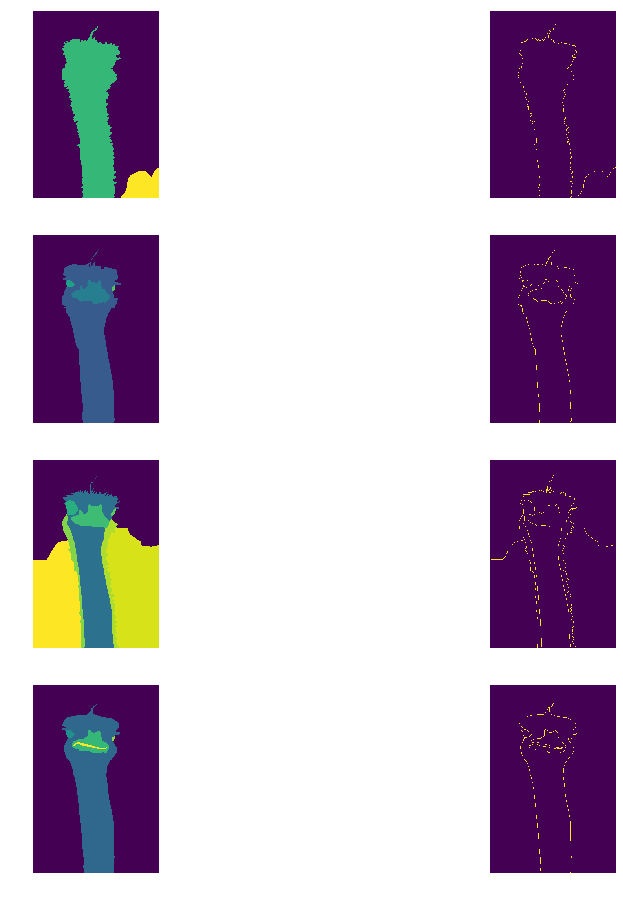

In [10]:
(im_array,mat) = readImage('66075')

#Segmentation using K-means (15 Points)


*   We will change the K of the K-means algorithm between {3,5,7,9,11} clusters.
You will produce different segmentations and save them as colored images. Every
color represents a certain group (cluster) of pixels.
*   We will evaluate the result segmentation using **F-measure**, **Conditional Entropy**.
for image I with M available ground-truth segmentations. For a clustering of
K-clusters you will report your measures M times and the average of the M trials
as well.



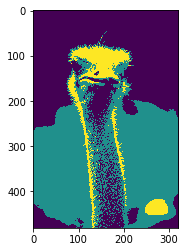

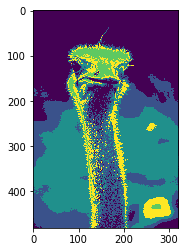

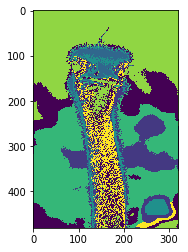

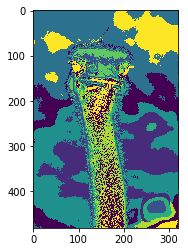

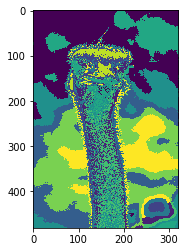

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
-------------------------------------------
0 'th cluster =>  [1 1 1 ... 4 4 4]
Sum of Elements: [56697     3 11548  1492]
-------------------------------------------
1 'th cluster =>  [3 3 3 ... 4 4 4]
Sum of Elements: [52197     0 18716  2423]
-------------------------------------------
2 'th cluster =>  [3 3 3 ... 3 3 3]
Sum of Elements: [  18    0 9815 1492]
Conditional Entropy: 0.6113139682372123
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
-------------------------------------------
0 'th cluster =>  [1 1 1 ... 1 1 1]
Sum of Elements: [58417     1  9958   985   287    90     1     1]
-------------------------------------------
1 'th cluster =>  [3 3 3 ... 1 1 1]
Sum of Elements: [55789     0 16586   939    22     0     0     0]
-------------------------------------------
2 'th cluster =>  [1 3 3 ... 3 3 3]
Sum of Elements: [1657    0 8025 1643    0    0    0    0]
Conditional Entropy: 0.5792691763283461
-*

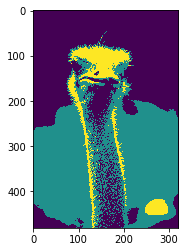

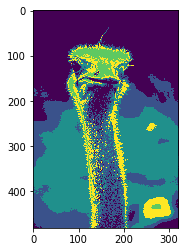

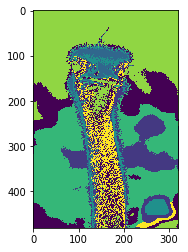

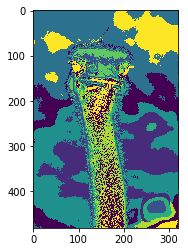

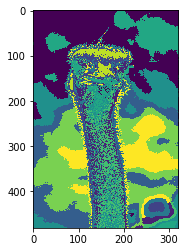

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
F1-Score --> Ground Truth [ 0 ] Segment # [ 0 ]:  0.53
F1-Score --> Ground Truth [ 1 ] Segment # [ 0 ]:  0.52
F1-Score --> Ground Truth [ 2 ] Segment # [ 0 ]:  0.54
F1-Score --> Ground Truth [ 3 ] Segment # [ 0 ]:  0.52
F1-Score --> Ground Truth [ 4 ] Segment # [ 0 ]:  0.52
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
F1-Score --> Ground Truth [ 0 ] Segment # [ 1 ]:  0.39
F1-Score --> Ground Truth [ 1 ] Segment # [ 1 ]:  0.38
F1-Score --> Ground Truth [ 2 ] Segment # [ 1 ]:  0.43
F1-Score --> Ground Truth [ 3 ] Segment # [ 1 ]:  0.38
F1-Score --> Ground Truth [ 4 ] Segment # [ 1 ]:  0.38
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
F1-Score --> Ground Truth [ 0 ] Segment # [ 2 ]:  0.33
F1-Score --> Ground Truth [ 1 ] Segment # [ 2 ]:  0.33
F1-Score --> Ground Truth [ 2 ] Segment # [ 2 ]:  0.41
F1-Score --> Ground Truth [ 3 ] Segment # [ 2 ]:  0.33
F1-Score --> Ground Truth [ 4 ] Segment # [ 2 ]:  

array([0.25375373, 0.25313634, 0.34590145, 0.25285751, 0.25688518])

In [11]:
getConditionalEntropy(getSegmentedKMeans(im_array,mat,np.array([3,5,7,9,11])),mat)
getFMeasure(getSegmentedKMeans(im_array,mat,np.array([3,5,7,9,11])),mat)

# Big Picture (10 Points)

**Select a set of five images and display their corresponding ground truth against
your segmentation results using K-means at K=5. Comment on the results. **

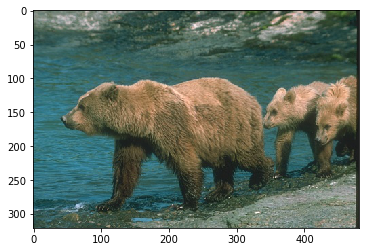

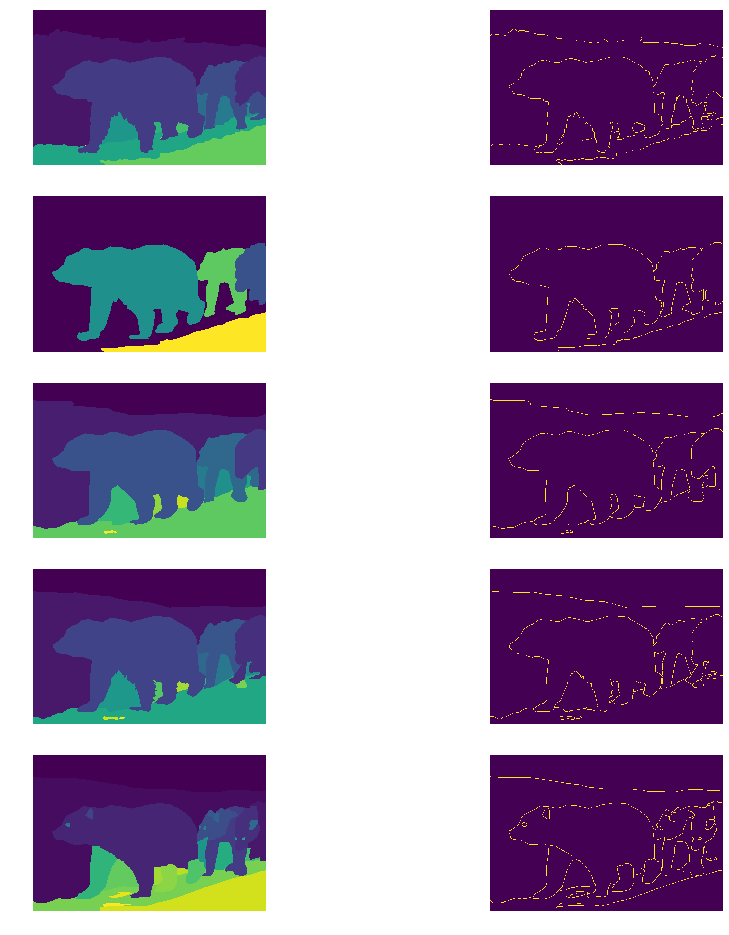

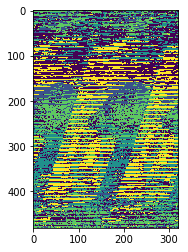

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
-------------------------------------------
0 'th cluster =>  [ 1  1  1 ... 14 14 14]
Sum of Elements: [12016 14143   479  7558  1440     0   275   453   182  1019  7491   105
   225   787    11     1     0     0]
-------------------------------------------
1 'th cluster =>  [ 1  1  1 ... 14 14 14]
Sum of Elements: [2884   48 1791 5920 2402    0    0    0    0    0  133    0    0 3743
    0    0    0    0]
-------------------------------------------
2 'th cluster =>  [ 1  1  1 ... 14 14 14]
Sum of Elements: [ 8166   670   371 11036  4303     0    20    87    19    72  4781    15
    51   429     2     0     1     2]
-------------------------------------------
3 'th cluster =>  [ 1  1  1 ... 14 14 14]
Sum of Elements: [ 5629   282  2174 13064  1387     1    26     1     1     0   652     0
     0  7721     0     0     0     0]
-------------------------------------------
4 'th cluster =>  [ 1  1  1 ... 14 14 14]
Sum of Elements:

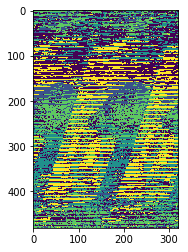

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
F1-Score --> Ground Truth [ 0 ] Segment # [ 0 ]:  0.39
F1-Score --> Ground Truth [ 1 ] Segment # [ 0 ]:  0.37
F1-Score --> Ground Truth [ 2 ] Segment # [ 0 ]:  0.39
F1-Score --> Ground Truth [ 3 ] Segment # [ 0 ]:  0.39
F1-Score --> Ground Truth [ 4 ] Segment # [ 0 ]:  0.39
F1-Score --> Ground Truth [ 5 ] Segment # [ 0 ]:  0.4


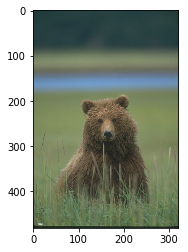

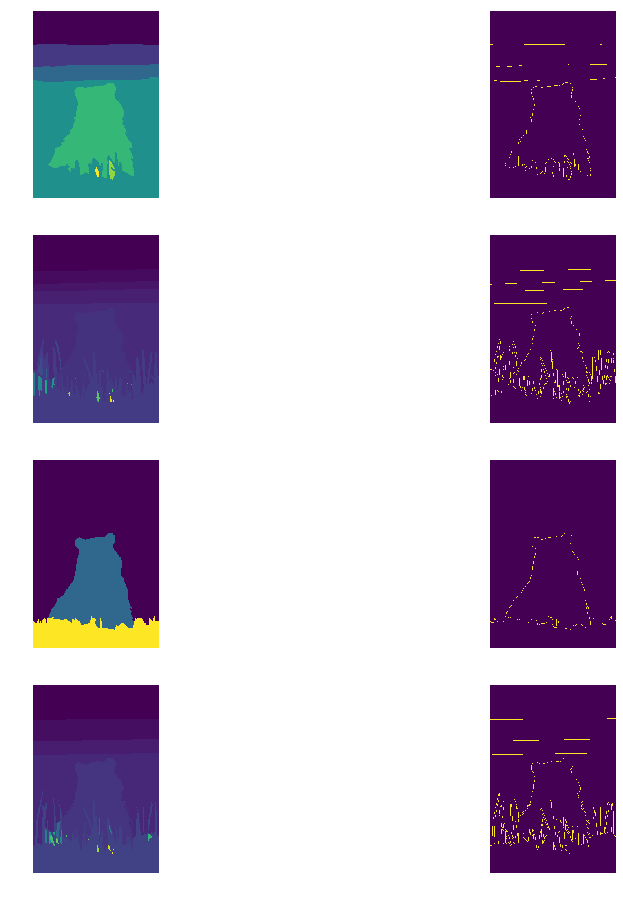

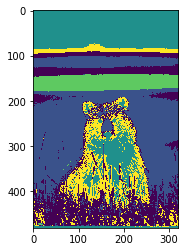

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
-------------------------------------------
0 'th cluster =>  [2 2 2 ... 4 4 4]
Sum of Elements: [    0  8316   482 19908  4205    80    15]
-------------------------------------------
1 'th cluster =>  [2 2 2 ... 4 4 4]
Sum of Elements: [    0  7223   986 40725  4833    11     0]
-------------------------------------------
2 'th cluster =>  [1 1 1 ... 4 4 4]
Sum of Elements: [26812     0     0  1439  9835   184     8]
-------------------------------------------
3 'th cluster =>  [3 3 3 ... 4 4 4]
Sum of Elements: [    0     3 10782    48    33     0     0]
-------------------------------------------
4 'th cluster =>  [1 1 1 ... 4 4 4]
Sum of Elements: [ 1602  1494     0  3901 11123   205   148]
Conditional Entropy: 0.8069468295053401
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
-------------------------------------------
0 'th cluster =>  [2 2 2 ... 7 7 7]
Sum of Elements: [    0  3208  4936   654  2096  3150 1

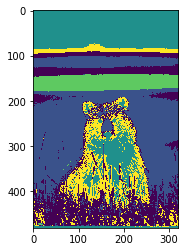

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
F1-Score --> Ground Truth [ 0 ] Segment # [ 0 ]:  0.66
F1-Score --> Ground Truth [ 1 ] Segment # [ 0 ]:  0.68
F1-Score --> Ground Truth [ 2 ] Segment # [ 0 ]:  0.45
F1-Score --> Ground Truth [ 3 ] Segment # [ 0 ]:  0.7
F1-Score --> Ground Truth [ 4 ] Segment # [ 0 ]:  0.66


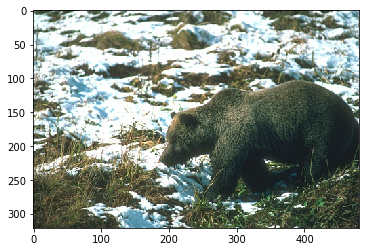

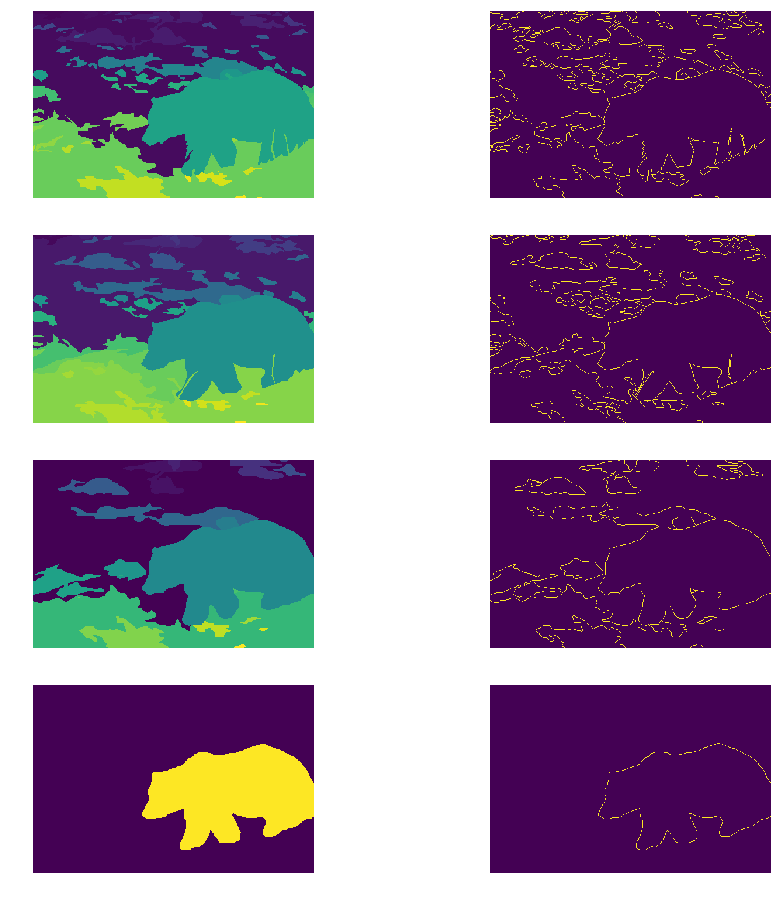

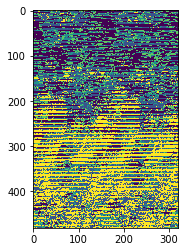

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
-------------------------------------------
0 'th cluster =>  [ 2  2  2 ... 67 67 67]
Sum of Elements: [    0    14 33211     5     3    31     1     0    18     0     0    38
     2     4    24     1     0     0    47     0     0     1     8     0
     6     0     0     0     9     2     9     0     0     0     0   276
     0     7    43     3     0     2     3    10     3    10    16    37
     1     9     3   239    37     4    77   193     9    27     6    61
  1189    75   295     0     6    38     7]
-------------------------------------------
1 'th cluster =>  [ 2  2  2 ... 52 52 52]
Sum of Elements: [    0   340  3034   188    23  3173  1255    28    46     0   227     0
    28    76    89    65    98     9     0    34     0    68   294    17
   101    12   113   121  1061   189  1917    64    22    92   123    29
   101   172  8352   301    30   116   189    11   117    77   447     9
    37     5    47 13926   560   

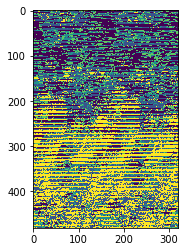

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
F1-Score --> Ground Truth [ 0 ] Segment # [ 0 ]:  0.45
F1-Score --> Ground Truth [ 1 ] Segment # [ 0 ]:  0.44
F1-Score --> Ground Truth [ 2 ] Segment # [ 0 ]:  0.44
F1-Score --> Ground Truth [ 3 ] Segment # [ 0 ]:  0.39
F1-Score --> Ground Truth [ 4 ] Segment # [ 0 ]:  0.41


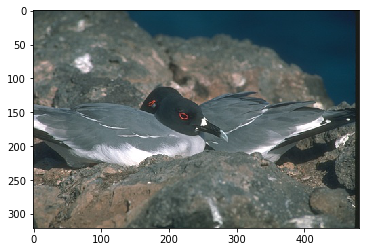

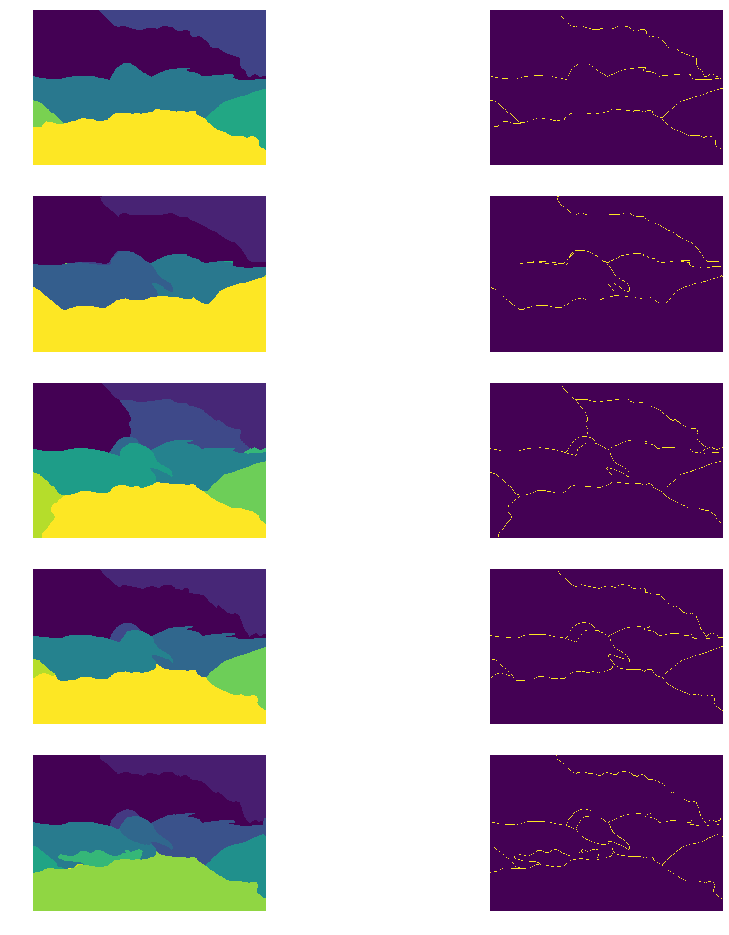

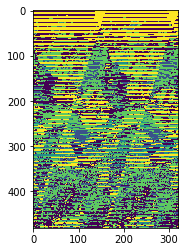

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
-------------------------------------------
0 'th cluster =>  [1 1 1 ... 6 6 6]
Sum of Elements: [17916   340  5906  2795   115 12479]
-------------------------------------------
1 'th cluster =>  [1 1 1 ... 6 6 6]
Sum of Elements: [5598    0 4761  610  157 7395]
-------------------------------------------
2 'th cluster =>  [1 1 1 ... 6 6 6]
Sum of Elements: [ 697    0 4569  179   12  590]
-------------------------------------------
3 'th cluster =>  [1 1 1 ... 6 6 6]
Sum of Elements: [17961    33 13639  1685   101 21184]
-------------------------------------------
4 'th cluster =>  [2 2 2 ... 6 6 6]
Sum of Elements: [  619 21657  6545  3771  1440  1647]
Conditional Entropy: 1.2009681913214958
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
-------------------------------------------
0 'th cluster =>  [ 1  1  1 ... 11 11 11]
Sum of Elements: [17762   193   166  3349  2709     0    31     6     4     0 15331]
------

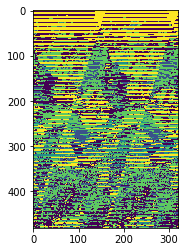

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
F1-Score --> Ground Truth [ 0 ] Segment # [ 0 ]:  0.42
F1-Score --> Ground Truth [ 1 ] Segment # [ 0 ]:  0.41
F1-Score --> Ground Truth [ 2 ] Segment # [ 0 ]:  0.4
F1-Score --> Ground Truth [ 3 ] Segment # [ 0 ]:  0.43
F1-Score --> Ground Truth [ 4 ] Segment # [ 0 ]:  0.47
F1-Score --> Ground Truth [ 5 ] Segment # [ 0 ]:  0.45


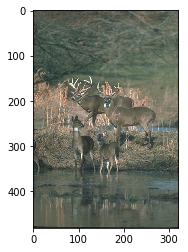

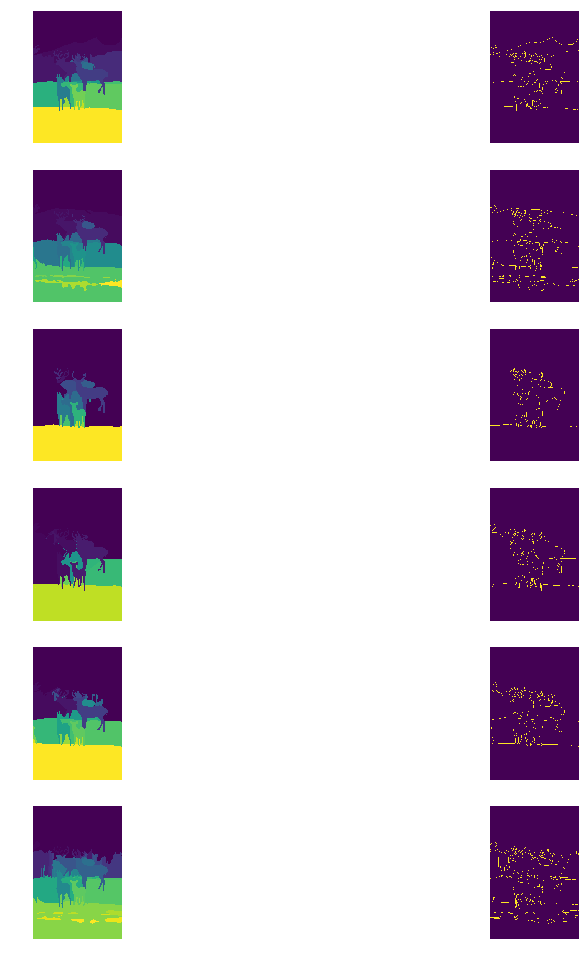

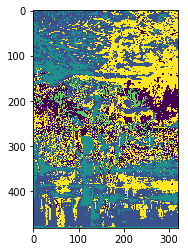

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
-------------------------------------------
0 'th cluster =>  [ 1  1  1 ... 34 34 34]
Sum of Elements: [ 638  531 4869  471 4839  138 1520    0   82   25    2   37   95  301
  462  138   22   63  202   41    9 1529  852  348    0 2867  420    0
    0   36   14    3    7  574]
-------------------------------------------
1 'th cluster =>  [ 1  1  1 ... 34 34 34]
Sum of Elements: [19495  4382   613  1091   255    71  1632     1     0     3     9     4
   480     9   643     5     1    19     3     2    15  2221   379    42
     1  2391   704     2   176    88    38    69    33 23430]
-------------------------------------------
2 'th cluster =>  [ 1  1  1 ... 34 34 34]
Sum of Elements: [8732  986  197  720  151    2  360    2    0    0    0    2   31    2
 1498    0    0    0    0    0    1 1410  186   13    0 2353  636   14
  352   33   97   61   28 7968]
-------------------------------------------
3 'th cluster =>  [ 3  3  3 ...

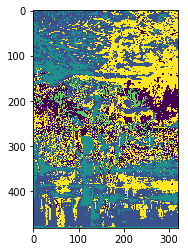

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
F1-Score --> Ground Truth [ 0 ] Segment # [ 0 ]:  0.31
F1-Score --> Ground Truth [ 1 ] Segment # [ 0 ]:  0.34
F1-Score --> Ground Truth [ 2 ] Segment # [ 0 ]:  0.28
F1-Score --> Ground Truth [ 3 ] Segment # [ 0 ]:  0.3
F1-Score --> Ground Truth [ 4 ] Segment # [ 0 ]:  0.28
F1-Score --> Ground Truth [ 5 ] Segment # [ 0 ]:  0.29
F1-Score --> Ground Truth [ 6 ] Segment # [ 0 ]:  0.27


In [12]:
images = ["100075","100080","100098","103041","104022"]
for i in images:
  (im_array,mat) = readImage(i)
  getConditionalEntropy(getSegmentedKMeans(im_array,mat,np.array([5])),mat)
  getFMeasure(getSegmentedKMeans(im_array,mat,np.array([5])),mat)

**Select the same five images and display their corresponding ground truth against
your segmentation results using Normalized-cut for the 5-NN graph, at K=5.
Comment on the results.**

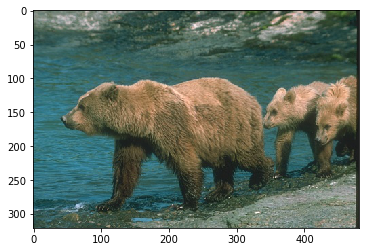

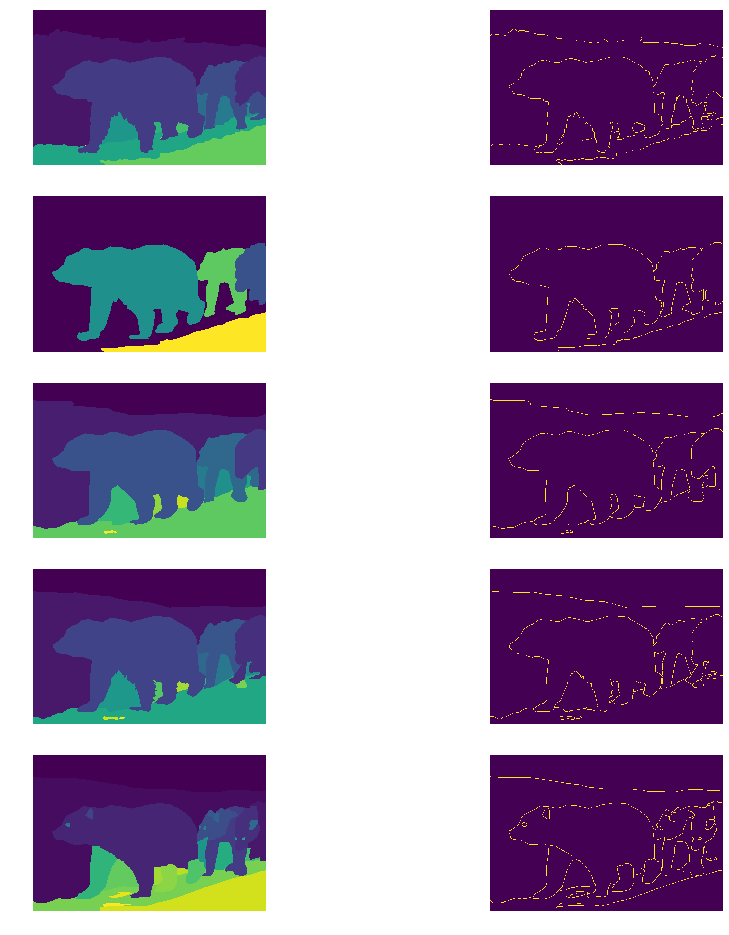

In [0]:
for i in images:
  (im_array,mat) = readImage(i)
  getConditionalEntropy(getSegmentedCuts(im_array,mat,np.array([5])),mat)
  getFMeasure(getSegmentedKMeans(im_array,mat,np.array([5])),mat)